In [18]:
!pip install --user numpy==1.21

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

In [2]:
SPX = pd.read_fwf('data/SPX.txt' ,names=['Date', 'Close'], parse_dates=True)

In [3]:
SPX.head()

,Date,Close
0,06/01/1995,"460,68"
1,13/01/1995,"465,97"
2,20/01/1995,"464,78"
3,27/01/1995,"470,39"
4,03/02/1995,"478,64"


In [4]:
VIX = pd.read_fwf('data/VIX.txt' ,names=['Date', 'Close'], parse_dates=True)

In [5]:
VIX.head()

,Date,Close
0,06/01/1995,"13,13"
1,13/01/1995,"11,1"
2,20/01/1995,"12,15"
3,27/01/1995,"11,25"
4,03/02/1995,"10,98"


In [6]:
SPX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1292 non-null   object
 1   Close   1292 non-null   object
dtypes: object(2)
memory usage: 20.3+ KB


In [7]:
SPX.describe()

,Date,Close
count,1292,1292
unique,1292,1243
top,28/12/2018,"1282,8"
freq,1,3


In [8]:
SPX['Close'] = SPX['Close'].apply(lambda x: float(x.split()[0].replace(',', '.')))
VIX['Close'] = VIX['Close'].apply(lambda x: float(x.split()[0].replace(',', '.')))

In [9]:
#SPX.index = pd.to_datetime(SPX.index,unit='ns')
#VIX.index = pd.to_datetime(VIX.index,unit='ns')
print(SPX.index)
print(VIX.index)

RangeIndex(start=0, stop=1292, step=1)
RangeIndex(start=0, stop=1292, step=1)


In [10]:
SPX.head()

,Date,Close
0,06/01/1995,460.68
1,13/01/1995,465.97
2,20/01/1995,464.78
3,27/01/1995,470.39
4,03/02/1995,478.64


In [11]:
SPX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1292 non-null   object 
 1   Close   1292 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.3+ KB


## **EVOLUTION DES NOS DONNEES**

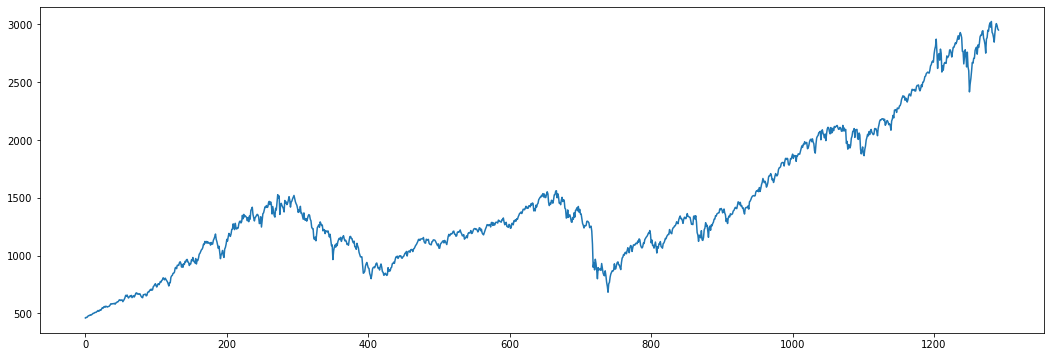

In [12]:
SPX['Close'].plot(figsize=(18, 6))
plt.show()

In [13]:
SPX_ = SPX.set_index('Date')

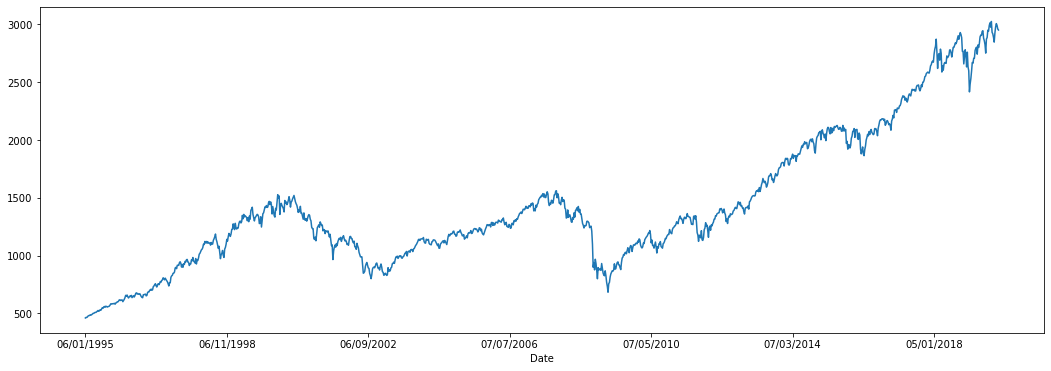

In [14]:
SPX_['Close'].plot(figsize=(18, 6))
plt.show()

In [15]:
SPX_data = SPX.copy()
SPX_data['Date'] = pd.to_datetime(SPX_data['Date'])
SPX_data = SPX_data.set_index('Date')
SPX_data.head()

,Close
Date,
1995-06-01,460.68
1995-01-13,465.97
1995-01-20,464.78
1995-01-27,470.39
1995-03-02,478.64


array([<AxesSubplot:xlabel='Date'>], dtype=object)

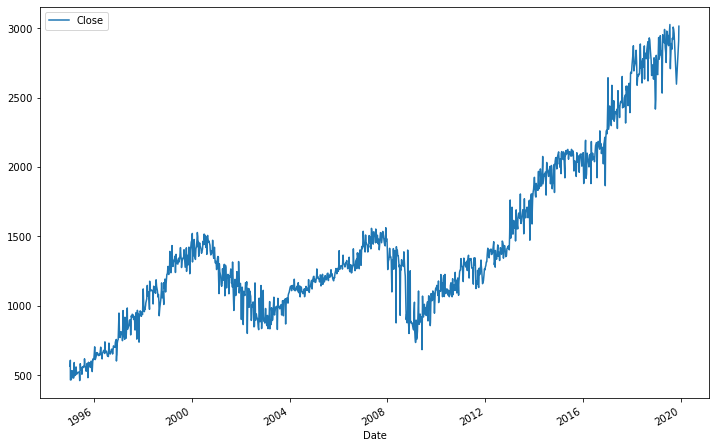

In [16]:
SPX_data[['Close']].plot(subplots=True, figsize=(12, 8))

In [ ]:
#df = SPX.copy()
#df.groupby('Date').resample('D').mean()

## SPLIT DATA

In [17]:
train_SPX = SPX.loc[0:890,'Close']
test_SPX = SPX.loc[890:,'Close']

Text(0, 0.5, 'SPX/USDT')

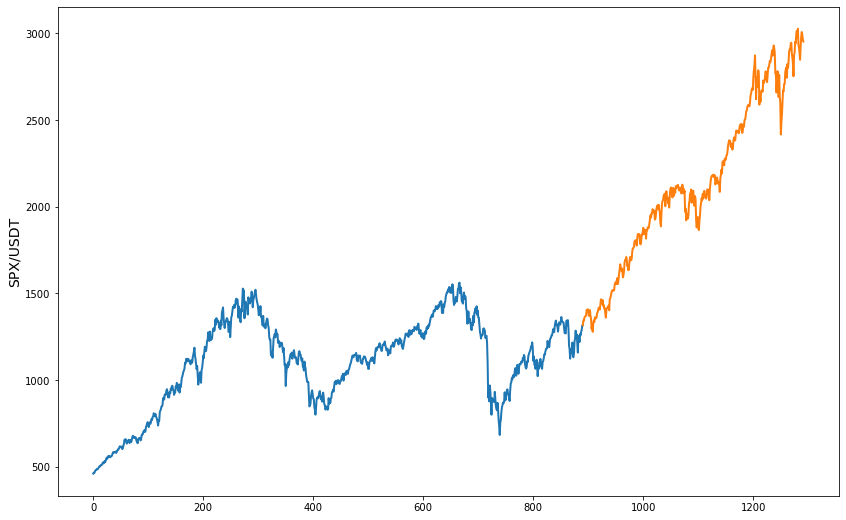

In [18]:
fig, ax = plt.subplots(1, figsize=(14, 9))
ax.plot(train_SPX, label='training data', linewidth=2)
ax.plot(test_SPX, label='test data', linewidth=2)
ax.set_ylabel('SPX/USDT', fontsize=14)

---

## TRAINING DATA

<AxesSubplot:>

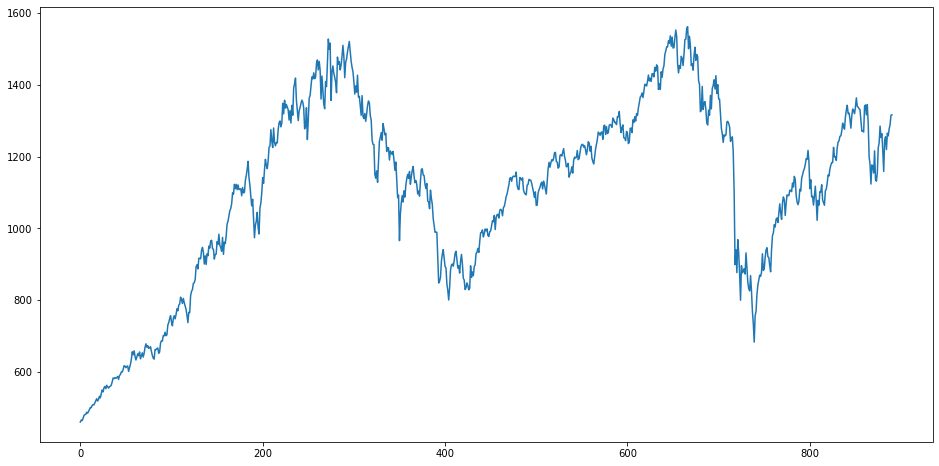

In [19]:
train_SPX.plot(figsize=(16,8))

## TEST DATA

<AxesSubplot:>

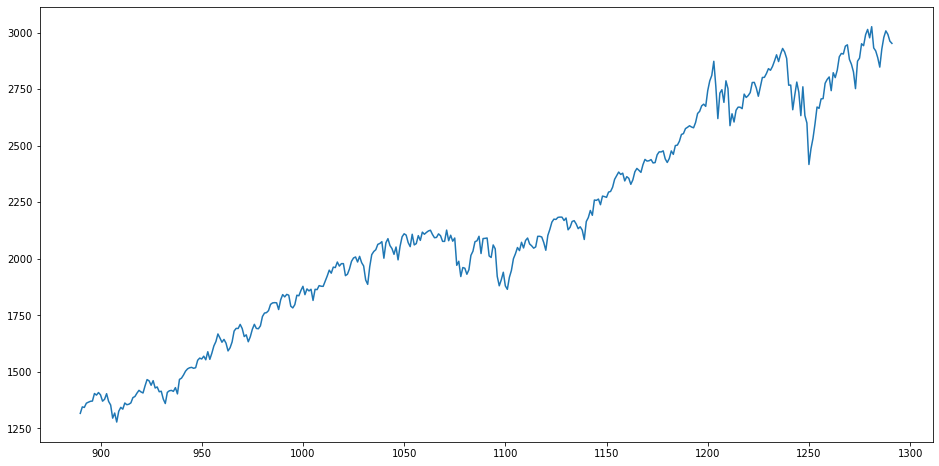

In [20]:
test_SPX.plot(figsize=(16,8))

# NORMALISATION DE DONNEES


In [21]:
def normalise_zero_base(data):
    return data / data.iloc[0] - 1

In [23]:
def prepare_data(train_SPX, test_SPX,window_len=10, zero_base=True, test_size=0.2):
    def extract_window_data(data, window_len=5, zero_base=True):
        window_data = []
        for idx in range(len(data) - window_len):
            tmp = data[idx: (idx + window_len)].copy()
            if zero_base:
                tmp = normalise_zero_base(tmp)
            window_data.append(tmp.values)
    return np.array(window_data)

    X_train = extract_window_data(train_SPX, window_len, zero_base)
    X_test = extract_window_data(test_SPX, window_len, zero_base)
    y_train = train_SPX[window_len:].values
    y_test = test_SPX[window_len:].values
    if zero_base:
        y_train = y_train / train_SPX[:-window_len].values - 1
        y_test = y_test / test_SPX[:-window_len].values - 1
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return train_SPX, test_SPX, X_train, X_test, y_train, y_test

# MODELISATION 1 LSTM

- Creation de modele lstm

In [24]:
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

- Les paramettres pour l'entrainement du model

## SPLIT DATA

In [26]:
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
train_SPX, test_SPX, window_len=5, zero_base=True, test_size=0.2)

NameError: name 'window_data' is not defined

In [ ]:
print('Len of X training data', X_train.shape)
print('Len of Y training data',y_train.shape)
print('------------------------------')
print('Len of X test data',X_test.shape)
print('Len of y test data',y_test.shape)

## TRAINING MODELE 1 LSTM

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=50, dropout=0.24, loss='mse',
    optimizer='adam')
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, verbose=1, shuffle=True)
     

## COURBE D'ENTRAINEMENT ET DE TEST

In [ ]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - SPX Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [ ]:
targets = test_SPX[window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

In [ ]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

In [ ]:
from sklearn.metrics import r2_score
r2_score1=r2_score(y_test, preds)
r2_score1*100

In [ ]:
preds = test_SPX.values[:-window_len] * (preds + 1)
preds

In [ ]:
#preds.plot(figsize=(16,8))

In [ ]:
preds = pd.Series(index=targets.index, data=preds)
preds

# PREDICTION DU MODEL 1 LSTM

In [ ]:
preds = pd.Series(index=targets.index, data=preds)
preds.plot(figsize=(10,8) , c='g')

## VRAIE DONNE DU TEST

In [ ]:
test_SPX.plot(figsize=(10,8), c='r')

## COMPARAISON DES VRAIE DONNEE AVEC LES PREDICTIONS

In [ ]:
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [ ]:
line_plot(test_SPX, preds, 'actual', 'prediction', lw=3)

## PREDICTION DU MODEL SUR LES DONNEES DE TEST

In [ ]:
train_SPX = SPX.loc[0:1110,'Close']
test_SPX = preds

def line_plot(line1, line2,line3 ,label1=None, label2=None, label3=None,title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(14, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw, c='orange')
    #ax.plot(line2, label=label2, linewidth=lw, c='o')
    ax.plot(line3, label=label3, linewidth=lw, c='g')
    ax.set_ylabel('SPX/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
line_plot(train_SPX, targets,preds, 'training','test', 'Prediction du modele', title="DONNEE D'ENTRAINEMNT ET DE TEST")

## MODEL 2 Recurrent Neural network AVEC KERAS

In [ ]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series
import keras
from keras import optimizers
from keras.layers import Activation, Dense,Dropout

In [ ]:
df = SPX.set_index('Date')
data=df.copy()

In [ ]:
data.head()

In [ ]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        #takes 
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
look_back=7
numpy.random.seed(0)

# load the dataset
dataframe = data
dataset = dataframe.values
dataset = dataset.astype('float64').reshape(-1, 1)
# normalize the dataset
scaler = MinMaxScaler()
#scaler=RobustScaler()
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
#look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network


## CREATE MODEL

In [ ]:
model = Sequential()

model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
#model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256))
model.add(Dense(1))

In [ ]:
predictions

## COMPILE MODEL

In [ ]:
#keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1)

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, verbose=1,shuffle=False,batch_size=50)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
predictions = numpy.empty_like(dataset)
predictions[:, :] = numpy.nan
predictions[look_back:len(trainPredict)+look_back, :] = trainPredict
predictions[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
#data=pd.DataFrame(numpy.concatenate((trainPredict[0:len(trainPredict)-look_back-1],testPredict[0:len(testPredict)-look_back-1])),columns=["predicted"])
#print('one',data.count())
#print('two',dataframe.count())
predictionsDF=pd.DataFrame(predictions,columns=["predicted"],index=dataframe.index)
ans=pd.concat([dataframe,predictionsDF],axis=1)
print( ans,[look_back,trainScore,testScore])

In [ ]:
line_plot(testX, testPredict, 'actual', 'prediction', lw=3)

In [ ]:
line_plot(SPX['Close'], predictions, 'actual', 'prediction', lw=3)

In [ ]:
train_SPX = SPX.loc[0:1110,'Close']
test_SPX = preds

def line_plot(line1, line2 ,label1=None, label2=None,title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(14, 9))
    ax.plot(line1, label=label1, linewidth=lw, c='r')
    ax.plot(line2, label=label2, linewidth=lw, c='g')
    ax.set_ylabel('SPX/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);


In [ ]:
line_plot(trainPredict, testPredict, 'training', 'Prediction du modele', title="DONNEE D'ENTRAINEMNT ET DE TEST")

In [ ]:
testX_ = scaler.inverse_transform(testX)

In [ ]:
testX_ = testX
testX_.shape

In [ ]:
testX_ = testX_.reshape(-1,)
testX_.shape

In [ ]:
testX_

In [ ]:
testX_ = scaler.inverse_transform(testX_)

In [ ]:
testX_

In [ ]:
line_plot(testX_, testPredict, 'training', 'Prediction du modele', title="DONNEE D'ENTRAINEMNT ET DE TEST")


In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
trainPredict.plot(figsize=(10,8), c='r')